<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">


# Recommendations: Collaborative Filtering Lab

_Author: Dan Wilhelm (LA) _

---

# Collaborative Filtering Lab

Today, we will be writing a User-Item Collaborative Filtering recommendation engine. This engine ranks each user by similarity to a given user. Then, it recommends brands from the most similar users, weighting each brand by the users' similarity.

Because Collaborative Filtering is relatively easy to implement and not part of Scikit-learn, we will be writing it from scratch using vanilla Python.

In [1]:
from collections import Counter

%matplotlib inline
from matplotlib import pyplot as plt

BRANDS_FILE = '../datasets/user_brand.csv'

## Load in User-Brands Data

In [2]:
from io import open

user_brands = dict()

with open(BRANDS_FILE, 'r', encoding='utf-8') as fin:
    data = [line.strip().split(",") for line in fin]

data[:20]

[['80002', 'Target'],
 ['80002', 'Home Depot'],
 ['80010', "Levi's"],
 ['80010', 'Puma'],
 ['80010', 'Cuisinart'],
 ['80010', 'Converse'],
 ['80010', 'DKNY'],
 ['80010', 'Express'],
 ['80010', "Kohl's"],
 ['80010', 'Old Navy'],
 ['80010', 'Container Store'],
 ['80010', 'Nordstrom'],
 ['80011', 'Kenneth Cole'],
 ['80011', 'Calvin Klein'],
 ['80011', 'French Connection'],
 ['80011', 'BCBGMAXAZRIA'],
 ['80011', 'Nine West'],
 ['80011', 'Steve Madden'],
 ['80011', 'Diesel'],
 ['80011', 'Guess']]

## Explore the Data

To assist you in exploring, make the following variables:

In [3]:
users = [line[0] for line in data]   # List of all users
brands = [line[1] for line in data]  # List of all brands

# user_brands = {'48132': {'Target', 'H&M', 'Gap'}, '31341': {'Zipcar'}, ... }
user_brands = {}
for user, brand in data:
    user_brands.setdefault(user, set()).add(brand)

# brand_users = {'Target': {'48132', '84172', '12353'}, 'Zipcar': {'31341'}, ... }
brand_users = {}
for user, brand in data:
    brand_users.setdefault(brand, set()).add(user)

1 - How many unique users are there?

In [4]:
len(set(users))

3759

2 - How many unique brands are there?

In [5]:
len(set(brands))

198

3 - What is the distribution of the number of brands liked by users?

_Hint:_ Make a list of ```likes_per_brand``` then plot a histogram! 

+ For example: ```plt.hist([1, 1, 1, 2, 2, 3], bins=3)```

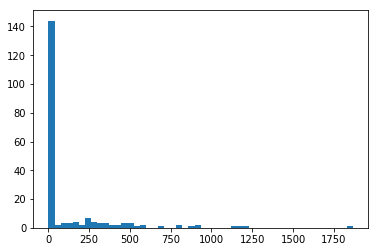

In [6]:
# list of number of brand likes
likes_per_brand = [len(us) for us in brand_users.values()]
    
plt.hist(likes_per_brand, bins=50);

4 - What is the distribution of the number of users who like a brand?

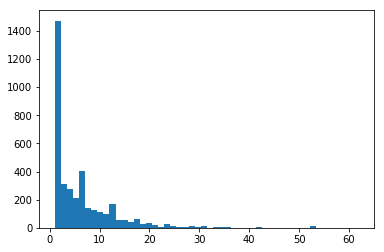

In [7]:
# list of number of brand likes
likes_per_user = [len(bs) for bs in user_brands.values()]

plt.hist(likes_per_user, bins=50);

5 - How many people like **Target**?

In [8]:
brands.count('Target')

1866

6 - How many people like **Banana Republic**?

In [9]:
brands.count('Banana Republic')

932

7 - What brands does **user 86184** like?

In [10]:
user_brands['86184']

{'DKNY', 'Express', 'Guess', "Kohl's", 'Old Navy', 'Target'}

8 - What brands does **user 83126** like?

In [11]:
user_brands['83126']

{'CB2', 'Container Store', 'Restoration Hardware', 'Serena and Lily'}

## Jaccard Distance Measure

Given two sets of brands, e.g. user1 = {'Target', 'Starbucks', 'Gap'} and user2 = {'Starbucks', 'Old Navy'}, the Jaccard distance is:

+ jaccard(u1, u2) = 1 - (# brands in common) / (# brands in total).

In [13]:
def jaccard(set1, set2):
    if (len(set1) == 0) and (len(set2) == 0):
        return Inf   
    # & = interesection
    # | = union
    return (float(len(set1 & set2)) / len(set1 | set2))

In [14]:
# Make test sets by hand, for example using 'Target' and 'Banana Republic'.
# Compute what the jaccard score should be for your test set.
# Does calling your function yield the same result?

# 1/2
jaccard({'Target'}, 
        {'Target', 'Banana Republic'})

0.5

## Weighted Jaccard

This metric does not fully capture our intution of distance between two users and the brands they like. For example, two users who have Target in common are less likely to be similar than users who have Autozone in common. So, let's add a weighting which emphasizes less frequent brands.

+ Weight each brand by 1/(brand's total likes). This is a useful measure, since we want a large weight with only 2 likes and a much smaller weight with 100 likes.
+ This weighting works because "Target" is liked by most users, so it is a less meaningful brand for similarity than "Zipcar".

In [15]:
# count how many times each brand appears in the entire dataset
brand_freq = Counter([line[1] for line in data])

def weighted_jaccard(set1, set2):
    return (float(sum(1. / brand_freq.get(brand) for brand in set1 & set2)) /
            sum(1. / brand_freq.get(brand) for brand in set1 | set2))

In [16]:
# Make test sets by hand, for example using 'Target' and 'Banana Republic'.
# Compute what the weighted jaccard score should be for your test set.
# Does calling your function yield the same result?

print(brand_freq.get('Target'), brand_freq.get('Banana Republic'))
print((1./1866) / (1./1866 + 1./932))

weighted_jaccard({'Target'}, {'Target', 'Banana Republic'})

1866 932
0.3330950679056469


0.3330950679056469

## Recommendation Engine

First, we'll define two already completed helper functions. 

```
# Pretty-prints similar brands to Target
similar_brands('Target')

# Pretty-prints brands that user 86184 will like
similar_users('86184') 
```



In [17]:
def similar_brands(brand_name):
    """
    Given a brand name **string**, returns a pretty-print string of 
        recommendations of more brands.
    """

    # IMPORTANT: 'recommend_for_brands' expects a set of brand names.
    #   So, because 'brand_name' is a string, we convert the single name 
    #   to a set containing the brand name

    recs = recommend_for_brands(set([brand_name]))

    return "For a user who likes {liked}, we recommend {recs}.".format(
        liked=brand_name,
        recs=", ".join(recs))

In [18]:
def similar_users(user):
    """
    Given a user name **string**, returns a pretty-print string 
      of recommendations for a user.
    """
    recs = recommend_for_user(user)

    return "For user {user}, who likes {liked}, we recommend {recs}.".format(
        user=user,
        liked=", ".join(user_brands.get(user, ["nothing"])),
        recs=", ".join(recs))

Next, we define how to recommend brands to users. Make sure you understand how it works -- we just ask for similar brands to the brands the user already likes. 

The below function is complete -- no additional code must be written!

In [19]:
def recommend_for_user(user_string):
    """
     Recommend items to a user that are similar 
     to the brands the user already likes
    """

    return recommend_for_brands(user_brands.get(user_string, set()))

    # NOTE: The second parameter to get() is the default
    #   value to send if the user is not a key in 'user_brands'

Finally, we implement recommending brands based on a list of brands. To do this, we will find the users closest to the brands set. Then, other brands that those users like will be recommended. 

Use the ```jaccard``` or ```jaccard_weighted``` as your distance function to rank users. Then, use your best judgement for how to collect the additional brands.

In [20]:
def recommend_for_brands(brands_set):
    """
    Return top five recommended brands
      based on the brands in 'brands_set'.
    """
    
    # The strategy is:
    #   (1) Find the users most similar to the 'brands_set'.
    #   (2) Get 5 brands those users also like
    #   (3) OPTIONAL: Weight the 5 brands by most unique to least unique

    # user_brands.items() = [('48132', {'Target', 'H&M', 'Gap'}, ('31341', {'Zipcar'}), ... }
    #  + 'sorted' sorts a tuple normally by its first element. 
    #  + We will instead sort by jaccard distance from the set of brands passed in.
    #  + 'key' is a number used to sort the items. 'x' stands for the current item
    #     being sorted, so it is the set of brands for the current user (see items() above).
    by_similarity = sorted(user_brands.items(),
                           key=lambda x: jaccard(brands_set, x[1]))

    # At this point, the user/brands dictionary is sorted by similarity to the 'brands_set'
    # For example:
    # + For brand_set = {"Kohl's", 'Old Navy', 'Guess', 'Target', 'Express', 'DKNY'}, then
    # + by_similarity[-5:] = [
    #    ('81511', {'Old Navy', 'Guess', 'Lacoste', 'Banana Republic', 'Express', 'DKNY'}), 
    #    ('90920', {"Kohl's", 'Old Navy', 'Guess', 'Crate & Barrel', 'BCBGMAXAZRIA', 'Express', 'DKNY', 'Home Depot'}), 
    #    ('82877', {'DKNY', 'Express', 'Guess'}),
    #    ('90464', {'DKNY', 'Express', "Kohl's", 'Target', 'Guess'}), 
    #    ('86184', {"Kohl's", 'Old Navy', 'Guess', 'Target', 'Express', 'DKNY'}))]


    unique_brands = {}
    
    # Until we get at least 5 unique brands ...
    while len(unique_brands) < 5:
        # For each unique brand of the most similar user, increment its weight
        #   NOTE: 'A - B' is the set difference (all in A that are not in B)
        #   NOTE: pop() removes the last element from a list
        for brand in by_similarity.pop()[1] - brands_set:
            unique_brands.setdefault(brand, 0)            # if key hasn't been added yet, set to 0
            unique_brands[brand] += 1 / brand_freq[brand] # increment by the inverse brand frequency
    
    # Sort by the weight and return the 5 most common brands
    return sorted(unique_brands, key=lambda x: unique_brands[x])[:5]
    
    # NOTE: You could alternatively make 'unique_brands' a Counter(),
    #       then return the most_common(5)

## Testing

In [23]:
# For testing, recommend brands similar to Target and Banana Republic
print(similar_brands("Target"))
print()
print(similar_brands("Banana Republic"))
print()

# For testing, recommend brands for users 86184 and 83126
#    NOTE: This is based on the brands each user likes
print(similar_users("86184"))
print()
print(similar_users("83126"))

For a user who likes Target, we recommend Gap, Puma, Home Depot, Columbia, Kohl's.

For a user who likes Banana Republic, we recommend Gap, Steve Madden, Guess, Calvin Klein, Betsey Johnson.

For user 86184, who likes Guess, DKNY, Express, Target, Old Navy, Kohl's, we recommend Crate & Barrel, Nine West, Levi's, BCBGMAXAZRIA, Home Depot.

For user 83126, who likes CB2, Serena and Lily, Restoration Hardware, Container Store, we recommend Target, Crate & Barrel, J.Crew, Crocs, 6pm.com.


## Recap

You just implemented User-Item collaborative filtering, making recommendations as follows:
+ **Step One:** Find users similar to the target user.
+ **Step Two:** Recommend things that similar users like.

## Challenge: Item-Item Collaborative Filtering

Now, let's try making an Item-Item recommendation system, as follows. Given a user, we will again recommend other brands the user may like. Instead of looking at other similar users, however, this time we will look at similar items to what the user likes:

+ **Step One:** Determine similarity of brands to one another. 
    - Of all users who like brand X, what other brands do they most like?


+ **Step Two:** Given a target user, recommend similar brands to the brands the user likes.

Note there may be many valid ways of implementing both steps!

In [24]:
# Often, this is computed overnight for all brands and 
#     stored for making quick recommendations

# For a given brand, returns the most similar other brands
def get_most_similar_brands(brand, max_n=10):
    other_brand_votes = Counter()
    
    
    # 1. Of the users who like this brand, 
    #     count how many times they like other brands.
    for user in brand_users[brand]:
        other_brand_votes.update(user_brands[user])
    
    
    # 2. Weight the brands to eliminate common ones such as Target.
    ### Let's weight the top liked brands by 1/(2 * brand freq) to make the results less Target-y
    most_similar_counts = other_brand_votes.most_common()
    for i,(curr_brand,nvotes) in enumerate(most_similar_counts):
        most_similar_counts[i] = (curr_brand, float(nvotes) / (2. * brand_freq[curr_brand]))
    ###
    
    # 3. Sort the brands by largest score and return only the names
    most_similar_counts = sorted(most_similar_counts, key=lambda x: -x[1])
    most_similar_brand_names = [x[0] for x in most_similar_counts if x[0] != brand]
    
    return most_similar_brand_names[:max_n]


get_most_similar_brands("The North Face")

['Patagonia',
 'Hanky Panky',
 'Nicole Miller',
 'Columbia',
 'Restoration Hardware',
 'BCBGMAXAZRIA',
 'New Balance',
 'Calvin Klein',
 'Cuisinart',
 'Steve Madden']

In [25]:
import random

def get_user_recommendations(user, max_n=10):
    final_brand_names = []
    
    # 1. Given the brands the user likes, return the similar brands!
    for x in user_brands[user]:
        similar_brands = get_most_similar_brands(x)
        final_brand_names.extend(similar_brands)
    
    return random.sample(final_brand_names, max_n)

get_user_recommendations('87026')

['YSL',
 'Charles David',
 'Barneys Warehouse',
 'Rip Curl',
 'Roxy',
 'Lancome',
 'Armani Exchange',
 'Billabong',
 'Bali',
 "O'Neill"]